# Postprocessing a FNN Trained for a Mass-Spring-Damper System 

In [1]:
### Loading Libraries

import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from tensorflow                           import keras

import romnet                             as rmnt

In [2]:
### Input Data

ROMNetFldr    = WORKSPACE_PATH + '/ROMNet/romnet/'
PathToRunFld  = WORKSPACE_PATH + '/ROMNet/0DReact_Isobaric_100Cases_POD_All/FNN/Deterministic/Run_2/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/FNN/MCDropOut/Run_1/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/FNN/BayesByBackprop/Run_2/'

TrainingCases = [0]#[0,2,4,6,8]
TestCases     = [0,2,4]#[0,2]

NSamples      = 100

Nt            = 100
tout          = np.linspace(0.,15.,Nt)
SOLVER        = 'Radau'

LineTypeVec   = ['-',':','--','.-']*10

In [3]:
print("\n[ROMNet]: Reading Input File from: ", PathToRunFld)
sys.path.insert(0, PathToRunFld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH, ROMNetFldr)


InputData.InputFilePath = PathToRunFld+'/ROMNet_Input.py'
InputData.TrainIntFlg   = 0
InputData.PathToRunFld  = PathToRunFld


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE//ROMNet/0DReact_Isobaric_100Cases_POD_All/FNN/Deterministic/Run_2/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


In [4]:
SurrogateType = InputData.SurrogateType
if (SurrogateType == 'FNN-SourceTerms'):
    SurrogateType = 'FNN'

Net   = getattr(rmnt.nn, SurrogateType)

model = rmnt.model.Model_Deterministic(InputData)

model.build(InputData, None, Net)

NN    = model.net


[ROMNet]:   Initializing the ML Model

[ROMNet]:   Building the ML Model

[ROMNet]:   Loading ML Model Parameters from File:  /Users/sventur/WORKSPACE//ROMNet/0DReact_Isobaric_100Cases_POD_All/FNN/Deterministic/Run_2//Training/Params//007417.h5
'load_params' took 0.010849 s


[ROMNet]:   Saving ML Model Parameters to File:  /Users/sventur/WORKSPACE//ROMNet/0DReact_Isobaric_100Cases_POD_All/FNN/Deterministic/Run_2//Model/Params/Initial.h5
'save_params' took 0.015118 s

'build' took 1.163269 s



iVar =  79


(1e-06, 0.01)

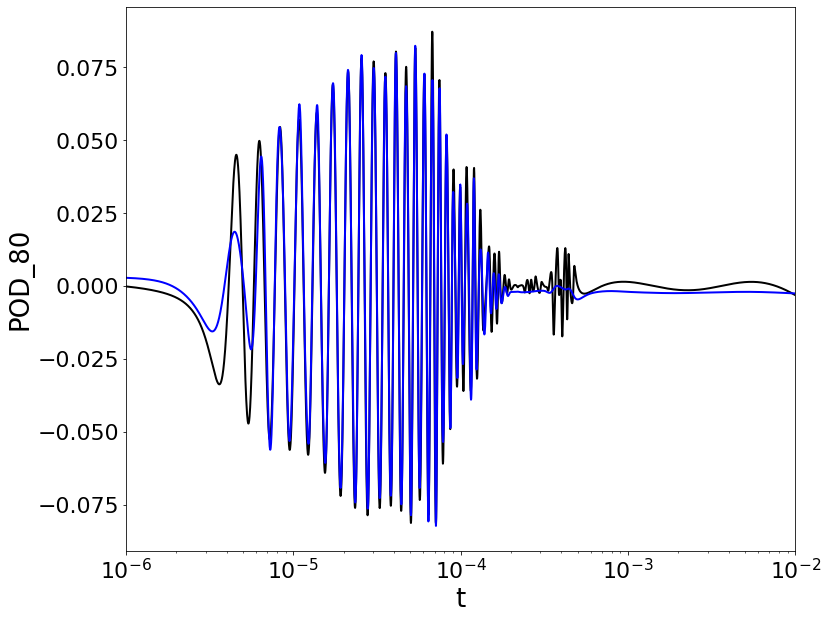

In [5]:
### Evaluating on Test Data

VarOI     = 'POD_80'

Vars      = ['POD_'+str(iPOD+1) for iPOD in range(InputData.NPODs)]

FileName  = InputData.PathToDataFld + '/test/ext/Input.csv'# + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
tVec      = Data['t'].to_numpy()[...,np.newaxis]
VarNames  = list(Data.columns).remove('t')

FileName  = InputData.PathToDataFld + '/test/ext/Output.csv'# + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
Output    = Data[Vars].to_numpy()


## Variable to Be Visualized
for iVar in range(len(Vars)):
    if (Vars[iVar] == VarOI):
        print('iVar = ', iVar)
        break

        
yMat = NN.predict(tVec)    

plt.figure(figsize=(12,10))
plt.plot(tVec, Output[:,iVar],  'k')
plt.plot(tVec, yMat[:,iVar],    'b')
plt.xlabel('t')
plt.ylabel(VarOI)
plt.xscale('log')
plt.xlim([1.e-6,1.e-2])
#plt.legend()
#plt.show()

In [6]:
print('[PCA]  Max % Error = ', np.max(abs((yMat - Output)/yMat)*100))
print('[PCA]  Max      SE = ', np.max((yMat - Output)**2))
print('[PCA] Mean % Error = ', np.mean(abs((yMat - Output)/yMat)*100))
print('[PCA]          MSE = ', np.mean((yMat - Output)**2))

[PCA]  Max % Error =  91744786.46420616
[PCA]  Max      SE =  2.2622888438859063
[PCA] Mean % Error =  734.094869944568
[PCA]          MSE =  0.00040504843573207713


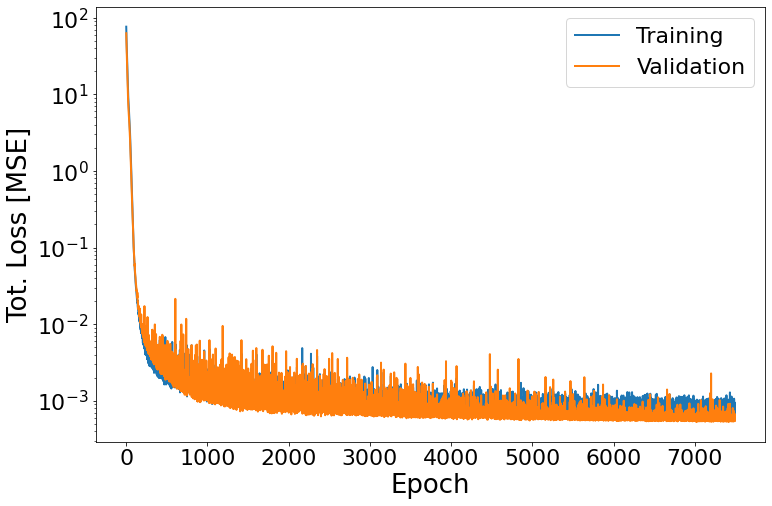

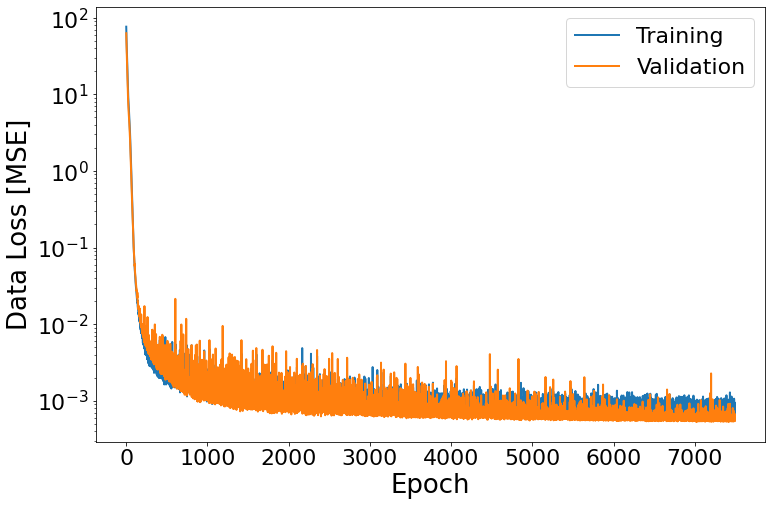

In [7]:
Data = pd.read_csv(PathToRunFld+'/Training/History.csv')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['tot_loss'],     label='Training')
plt.plot(Data['val_tot_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')


fig  = plt.figure(figsize=(12,8))
plt.plot(Data['pts_loss'],     label='Training')
plt.plot(Data['val_pts_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['scs_loss'],     label='Training')
# plt.plot(Data['val_scs_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('S.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

In [8]:
OutputDir = InputData.PathToDataFld

FileName = OutputDir+'/ROM/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/ROM/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/ROM/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

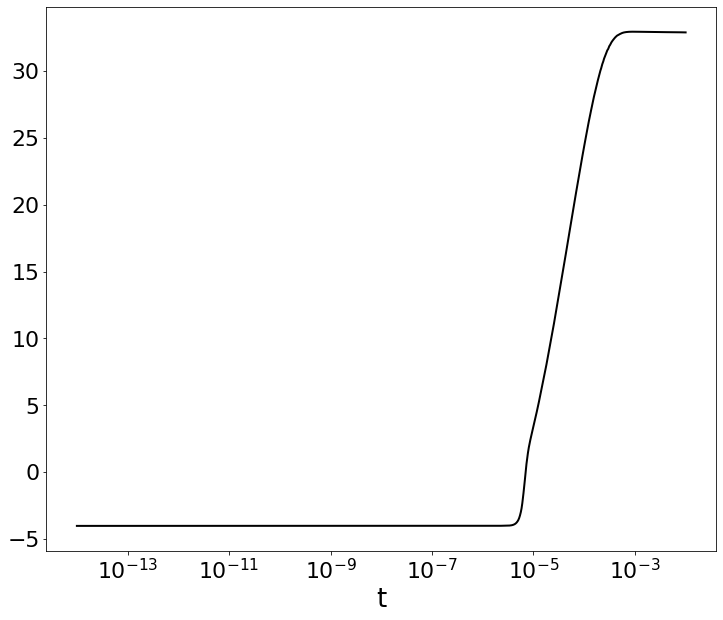

In [9]:
yMat_pod_  = NN.predict(tVec)    
yMat_      = (yMat_pod_.dot(A))*D[:,0] + C[:,0]


plt.figure(figsize=(12,10))
plt.plot(tVec, yMat_[:,20],  'k')
plt.xlabel('t')
plt.xscale('log')
#plt.legend()
#plt.show()

In [10]:
[NN.layers[i].name for i in range(len(NN.layers))]

['Trunk_1_Transformation_log',
 'Trunk_1_Normalization',
 'Trunk_1_HL1',
 'dropout',
 'Trunk_1_HL2',
 'dropout_1',
 'Trunk_1_HL3',
 'dropout_2',
 'Trunk_1_HL4',
 'dropout_3',
 'Trunk_1_HL5']

In [11]:
# NN.layers[0]._name = 'Trunk_1_Normalization'

# iLVec = [i for i in range(len(NN.layers)) if 'HL' in NN.layers[i].name]
# for jL, iL in enumerate(iLVec):
#     NN.layers[iL]._name              = 'Trunk_1_HL'+str(jL+1)
#     NN.layers[iL].weights[0]._name   = 'Trunk_1_HL'+str(jL+1)+'/kernel:0'
#     NN.layers[iL].weights[1]._name   = 'Trunk_1_HL'+str(jL+1)+'/bias:0'
#     NN.layers[iL].variables[0]._name = 'Trunk_1_HL'+str(jL+1)+'/kernel:0'
#     NN.layers[iL].variables[1]._name = 'Trunk_1_HL'+str(jL+1)+'/bias:0'
    
# [NN.layers[i].name for i in range(len(NN.layers))]

In [12]:
try:
    os.makedirs(InputData.PathToDataFld+'/FNN/')
except:
    pass

NN.save_weights(InputData.PathToDataFld+'/FNN/Final.h5', overwrite=True, save_format='h5')

In [13]:
# NN.save(InputData.PathToDataFld+'/FNN/Model')

In [14]:
import h5py
filename = "file.hdf5"

with h5py.File(InputData.PathToDataFld+'/FNN/Final.h5', "r") as f:
    print("Keys: %s" % f.keys())

#     # Get the data
#     data1 = f['NN_POD_1_HL5/NN_POD_1_HL5/kernel:0'][:]

#     data2 = f['NN_POD_1_HL4/NN_POD_1_HL4/bias:0'][:]
#     print(data)

Keys: <KeysViewHDF5 ['Trunk_1_HL1', 'Trunk_1_HL2', 'Trunk_1_HL3', 'Trunk_1_HL4', 'Trunk_1_HL5', 'Trunk_1_Normalization', 'Trunk_1_Transformation_log', 'dropout', 'dropout_1', 'dropout_2', 'dropout_3', 'top_level_model_weights']>


In [15]:
PathToPODFile = '/Users/sventur/WORKSPACE/ROMNet/Data/0DReact_Isobaric_100Cases_Try2/7PC/POD_All/FNN/Final.h5'

with h5py.File(PathToPODFile, "r") as f:
    Key_       = 'NN_POD_1_Normalization'
    Mean       = np.array(f[Key_+'/mean:0'][:])
    Variance   = np.array(f[Key_+'/variance:0'][:])[...,np.newaxis]
    MinVals    = np.array(f[Key_+'/min_vals:0'][:])[...,np.newaxis]
    MaxVals    = np.array(f[Key_+'/max_vals:0'][:])[...,np.newaxis]

OSError: Unable to open file (unable to open file: name = '/Users/sventur/WORKSPACE/ROMNet/Data/0DReact_Isobaric_100Cases_Try2/7PC/POD_All/FNN/Final.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)